In [1]:
%pylab inline

import os,sys
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches


from collections import defaultdict, Counter, OrderedDict

import cytograph as cg
import loompy
import palettable

sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
from scbeta_scrnaseq import utils
from scbeta_scrnaseq import vis
import scbeta_scrnaseq.cytograph_inmem_utils as cgm
import scbeta_scrnaseq.cytograph_analyses as cga

from scbeta_scrnaseq.figure_vis import core_colors
import scbeta_scrnaseq.figure_vis as fv


fv.setup_matplotlib_params()
mm_per_inch = 25.4

Populating the interactive namespace from numpy and matplotlib


In [2]:
samples = ["reagg"]


tds = OrderedDict()
for tp in samples:
    loom_fn = f'../04_Misc/data/complete_processing/reagg.processed.loom'
    tds[tp] = loompy.connect(loom_fn)
    tds[tp].vals = sp.sparse.csr_matrix(tds[tp].layers[""][:, :])

In [3]:
# for tp in tds:
#     tds[tp].close()

In [4]:
# import glob

# pb_tpm = {}
# for pbf in glob.glob('../*/data/complete_processing/*.pseudobulk_tpm.df.npz'):
#     key = os.path.basename(pbf)[:-(len('.pseudobulk_tpm.df.npz'))]
#     pb_tpm[key] = utils.load_df(pbf)
    
# pb_expr = {}
# for pbf in glob.glob('../*/data/complete_processing/*.expr_frac.df.npz'):
#     key = os.path.basename(pbf)[:-(len('.expr_frac.df.npz'))]
#     pb_expr[key] = utils.load_df(pbf)

In [6]:
label_order = ['scbeta', 'ec', 'ph', 'exo', 'repl']
ratio_order =['scbeta', 'ec', 'ph', 'exo', 'repl']

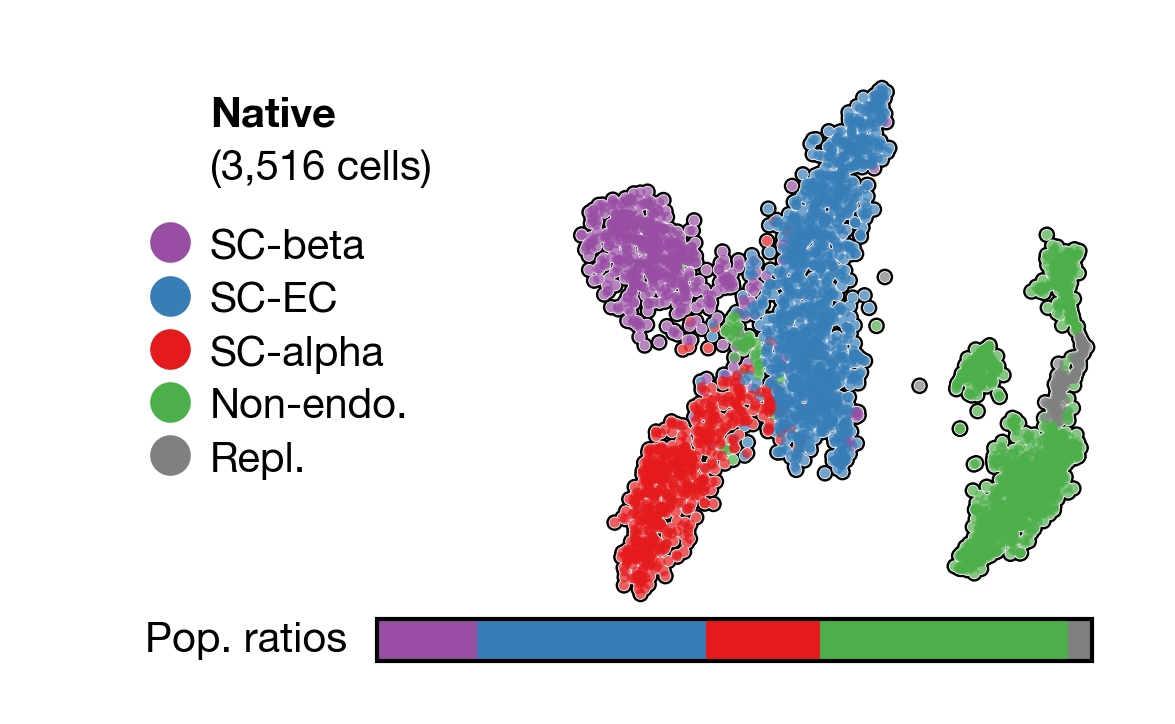

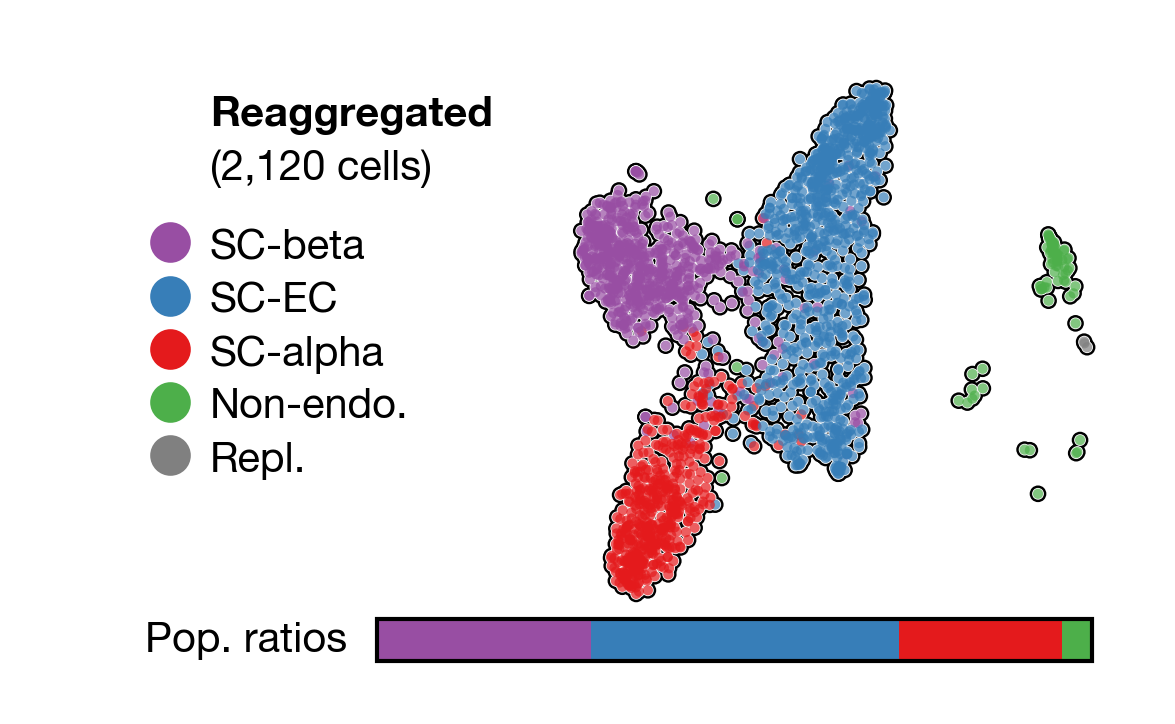

In [7]:
for cc in ['Native', "Reagg"]:

    
    panel_sizing = ((89/2)/mm_per_inch, #Width
                    (25.4)/mm_per_inch, #Height
                    ) 

    cell_pop_bar_h = 0.07

    heights = ((1 - cell_pop_bar_h)*panel_sizing[1],
                     cell_pop_bar_h * panel_sizing[1])
    widths = (panel_sizing[0] - heights[0],
                heights[0])


    fig = plt.figure(figsize=panel_sizing, dpi=600)
    gs = gridspec.GridSpec(2, 2, fig, 0,0,1,1,
                           hspace=0, wspace=0,
                           width_ratios=widths,
                           height_ratios=heights)


    si = 0
    _ds = tds['reagg']
    tsne_proj = _ds.ca['TSNE']
    cell_cond = _ds.ca['CellCondition']
    cell_clusters = _ds.ca['Labels']
    label_params = fv.dataset_label_params('stage6')

    cc_cells = cell_cond==cc
    
    ###### Draw the labels
    # 
    #

    ax = fig.add_subplot(gs[0, 2*si + 0], xticks=[], yticks=[], xlim=[0,1], ylim=[0,1],
              xscale='linear', yscale='linear',
              frameon=False)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xticks([])
    ax.set_yticks([])

    li = 1
    yl_pos = lambda lii: 1 - lii/10.5
    xl_pos_dot = 0.22
    xl_pos_header = 0.30
    xl_pos_text = 0.30

    ax.text(xl_pos_header, yl_pos(li), 'Native' if cc=='Native' else 'Reaggregated', verticalalignment='center', fontsize=5,
            fontdict=dict(weight='bold'),
            clip_on=False)
    li += 1


    ax.text(xl_pos_header, yl_pos(li), '(%s cells)'%format(sum(cc_cells),',d'), verticalalignment='center', fontsize=5,
            clip_on=False)
    li += 1.5

    _present_labels = set(cell_clusters)
    for lb in [lb for lb in label_order if lb in _present_labels]:
        lb_text = label_params[lb]['short_label']
        ax.scatter(xl_pos_dot, yl_pos(li)+0.01, s=15, clip_on=False, c=label_params[lb]['color'].reshape(1,-1))
        for leg_label_line in lb_text.splitlines():            
            ax.text(xl_pos_text, yl_pos(li), leg_label_line, verticalalignment='center', fontsize=5,clip_on=False)
            li += 1

    ###### Scatter plot
    # 
    #

    _proj, _c = fv.prepare_for_scatter(tsne_proj[cc_cells], cell_clusters[cc_cells], label_params) 

    ax = fig.add_subplot(gs[0, 2*si + 1], xticks=[], yticks=[],
                  xscale='linear', yscale='linear',
                  frameon=False,  zorder=-1)
    ax.patch.set_visible(False)

    s_black, s_white, s_type = 4, 2, 1.5
    ax.scatter(_proj[:, 0], _proj[:, 1], c='k', edgecolor='none', s=s_black, 
                   rasterized=True)
    ax.scatter(_proj[:, 0], _proj[:, 1], c='w', edgecolor='none', s=s_white, 
                   rasterized=True)
    ax.scatter(_proj[:, 0], _proj[:, 1], c=_c, edgecolor='none', s=s_type, alpha=0.7,
                   rasterized=True)



    ###### Population Ratio Indicator
    # 
    #

    # for wk in range(6):

    ax = fig.add_subplot(gs[1, (2*si):(2*si + 2)], 
                  xticks=[], yticks=[],       
                  xlim=[0,1], ylim=[0,1],
                  xscale='linear', yscale='linear',
                  frameon=False)

    n_by_cluster = pd.Series(Counter(cell_clusters[cell_cond == cc]))
    n_by_cluster = n_by_cluster/n_by_cluster.sum()

    cumul_frac = 0
    for lb in ratio_order:
        if lb in n_by_cluster:
            cl_frac = n_by_cluster[lb]
            ax.add_patch(
                patches.Rectangle(
                    (0.30 + 0.68*cumul_frac, 0.02), (0.68*cl_frac), 1.0,
                    facecolor=label_params[lb]['color'], edgecolor='none',
                    clip_on=False,
                ))
            cumul_frac += cl_frac

    ax.set_xlim([0,1])
    ax.set_ylim([0,1])


    ax.text(0.175, 0.5, f'Pop. ratios', verticalalignment='center', horizontalalignment='center', fontsize=5,
            clip_on=False)
    ax.add_patch(
            patches.Rectangle(
                (0.30, 0.02), 0.68, 1.0,
                facecolor='none', edgecolor='k', linewidth=0.5, clip_on=False,
            ))

    fig.savefig(f'../../figures/components/extended_figure7/ExtendedFigure7A.{cc}.pdf', dpi=600)
